## Notebook Structure
- Load and understand data
- Data cleaning and preprocessing
    - lemmatization
    - pos tagging
    - regex filtering
- Data Visualisation
    - character lengeth distribution
    - word cloud
    - unigram, bigram, trigram
- Feature Extraction
    - TF-IDF
- Topic Modelling
    - NMF
- Model building and Inference
    - Logistic regression
    - Decision Tree
    - Random Forest

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [5]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from wordcloud import WordCloud
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# pip install wordcloud

In [7]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head()

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
#Fucntion to remove the '_source.' preceding text from few columns
def set_new_column_name(old_col):
    new_col = old_col.replace('_source.','')
    df.rename(columns = {old_col: new_col},inplace=True)

In [13]:
#Assign new column names
for col in df.columns:
    set_new_column_name(col)
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [16]:
#Rename the complaint column
df.rename(columns ={'complaint_what_happened': 'complaint'}, inplace =True)

In [17]:
#Assign nan in place of blanks in the complaints column
len(df[df['complaint']==''])

57241

In [18]:
df.complaint = df.complaint.apply(lambda x : np.nan if len(str(x).strip()) == 0 else x)
len(df[df.complaint == ''])

0

In [70]:
#Remove all rows where complaints column is nan
df = df[df['complaint'].notna()]
len(df)

21072

In [20]:
df = df[["complaint"]].copy()

In [21]:
df.head()

,complaint
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,Chase Card was reported on XX/XX/2019. However...
11,"On XX/XX/2018, while trying to book a XXXX XX..."
14,my grand son give me check for {$1600.00} i de...


## Data Preprocessing (Lemmatization and Topic Modelling)

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [141]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean(df, col_name):
    
    def preprocess(row, pattern = r'\b(x)+\b'):
        '''
            skips punctuations and alphanumeric words
            adds lemmatized word
        '''
        words = []
        words_with_pos = []
        for token in nlp(row['preprocessed']):
            lemma = token.lemma_
            pos = token.pos_
            
            if pos == 'PUNCT' or not lemma.isalpha() or pos != 'NOUN':
                continue
                
            if re.match(pattern, lemma):
                continue
            
            words.append(lemma)
            words_with_pos.append('{}:{}'.format(lemma, pos))
            
        row['tokens'] = words
        row['tokens_with_pos'] = words_with_pos
        return row
                        
    # change case to lower
    df['preprocessed'] = df[col_name].str.lower()
    
    # remove text in square brackets 
    df['preprocessed'] = df['preprocessed'].replace('\[(.*?)\]', '', regex=True)
    
    # tokenize sentence into words and words with pos
    df = df.apply(lambda row : preprocess(row), axis=1)
    return df
    
df_clean = df.copy()
df_clean = clean(df_clean, 'complaint')
df_clean.head()

,complaint,preprocessed,tokens,tokens_with_pos
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx/xx/2018 and...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers..."
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","on xx/xx/2018, while trying to book a xxxx xx...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:..."
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU..."


In [73]:
df.complaint[317:318].values

array(['I have no idea why Chase keep on rejecting my credit card applications for no good reasons. I have a credit score of XXXX and never been a single late payment. I had this offer for XXXX XXXX credit card with {$70.00} cash back via gift card. I Applied but rejected by Chase. \nReached out to Chase multiple times - calls are getting dropped. they sent some online letter but i have no idea how to access it.'],
      dtype=object)

In [584]:
#Write your function to Lemmatize the texts


In [585]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 


In [142]:
df_clean.head()

,complaint,preprocessed,tokens,tokens_with_pos
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx/xx/2018 and...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers..."
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","on xx/xx/2018, while trying to book a xxxx xx...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:..."
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU..."


In [587]:
#Write your function to extract the POS tags 

In [143]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.drop(columns=['complaint'],axis=1,inplace=True)

In [144]:
df_clean.head()

,preprocessed,tokens,tokens_with_pos
1,good morning my name is xxxx xxxx and i apprec...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN..."
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers..."
10,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden..."
11,"on xx/xx/2018, while trying to book a xxxx xx...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:..."
14,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU..."


## Exploratory data analysis

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [145]:
# Function to get sentecnce length
df_clean["complaint_length"] = df_clean["preprocessed"].apply(lambda complain : len(str(complain)))

In [146]:
# Function to get word frequency in a sentence
def check_word_frequency(text):
    return len(str(text).split(' '))

In [147]:
df_clean['word_freq'] = df_clean['preprocessed'].apply(check_word_frequency)
df_clean['word_freq'].mean()

253.87196279422932

In [148]:
df_clean['word_freq'].describe()

count    21072.000000
mean       253.871963
std        271.628750
min          1.000000
25%         97.000000
50%        181.000000
75%        321.000000
max       5526.000000
Name: word_freq, dtype: float64

In [149]:
df_clean['complaint_length'].describe()

count    21072.000000
mean      1383.386105
std       1500.584774
min         19.000000
25%        528.000000
50%        983.000000
75%       1738.000000
max      31611.000000
Name: complaint_length, dtype: float64

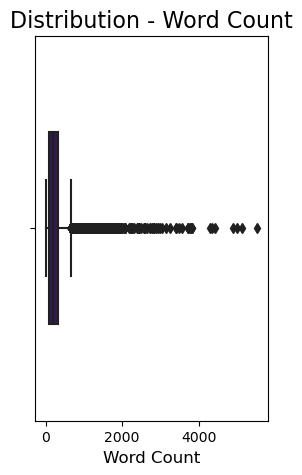

In [150]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(3,5))

sns.boxplot(
    df_clean['word_freq'],
    orient='v',
    width=.5,
    color='#30105C'
)
plt.xlabel("Word Count", fontsize=12)
plt.title('Distribution - Word Count', fontsize=16)
plt.yticks(np.arange(0, 100, 100))

file_name = 'box_plot'
'''
fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)
'''
plt.show()


<AxesSubplot:xlabel='complaint_length'>

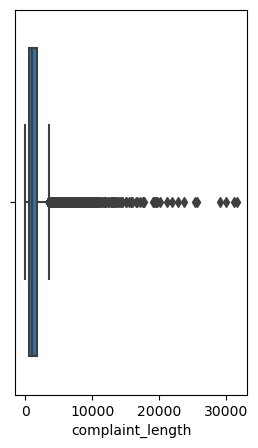

In [151]:
# Plot a boxplot of the cpm
fig = plt.figure(figsize=(3,5))
sns.boxplot(df_clean['complaint_length'])

#### Find the top 40 words by frequency among all the articles after processing the text.

### WordCloud

In [152]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
df_clean['preprocessed'][10]

'chase card was reported on xx/xx/2019. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.'

In [153]:
complaint_words = [word for word_list in df_clean['tokens'] for word in word_list]

In [154]:
len(complaint_words)

1138122

In [156]:
# removing the 'xxxx' word
complaint_words_list = [word for word in complaint_words if word != 'xxxx']

In [157]:
nltk.FreqDist(complaint_words_list).most_common(40)

[('chase', 74018),
 ('account', 47660),
 ('credit', 32809),
 ('card', 30515),
 ('bank', 28075),
 ('payment', 21311),
 ('time', 16281),
 ('day', 13207),
 ('charge', 12254),
 ('money', 11980),
 ('loan', 11003),
 ('check', 10411),
 ('letter', 9700),
 ('information', 9670),
 ('fee', 8997),
 ('transaction', 8643),
 ('number', 8617),
 ('month', 8586),
 ('year', 8420),
 ('amount', 8317),
 ('mortgage', 8197),
 ('customer', 8189),
 ('balance', 7794),
 ('service', 7654),
 ('company', 7643),
 ('phone', 7594),
 ('fraud', 7175),
 ('report', 7066),
 ('fund', 7049),
 ('call', 6651),
 ('claim', 6590),
 ('business', 5630),
 ('email', 5482),
 ('interest', 5424),
 ('statement', 5282),
 ('issue', 5277),
 ('dispute', 5097),
 ('complaint', 5072),
 ('branch', 5031),
 ('date', 5026)]

In [158]:
word_dist = pd.DataFrame(nltk.FreqDist(complaint_words_list).items() ,columns = ['word','WordCount_pos'])
word_dist = word_dist.set_index('word')

In [159]:
most_freq_words = word_dist.sort_values(by='WordCount_pos',ascending=False)

In [160]:
most_freq_words.head(40)

,WordCount_pos
word,
chase,74018
account,47660
credit,32809
card,30515
bank,28075
payment,21311
time,16281
day,13207
charge,12254


In [161]:
top40_words = most_freq_words.head(40).index

In [162]:
top40_words

Index(['chase', 'account', 'credit', 'card', 'bank', 'payment', 'time', 'day',
       'charge', 'money', 'loan', 'check', 'letter', 'information', 'fee',
       'transaction', 'number', 'month', 'year', 'amount', 'mortgage',
       'customer', 'balance', 'service', 'company', 'phone', 'fraud', 'report',
       'fund', 'call', 'claim', 'business', 'email', 'interest', 'statement',
       'issue', 'dispute', 'complaint', 'branch', 'date'],
      dtype='object', name='word')

In [163]:
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0, collocations=False)

In [164]:
text = ' '.join([w for w in complaint_words_list if w in top40_words.tolist()])

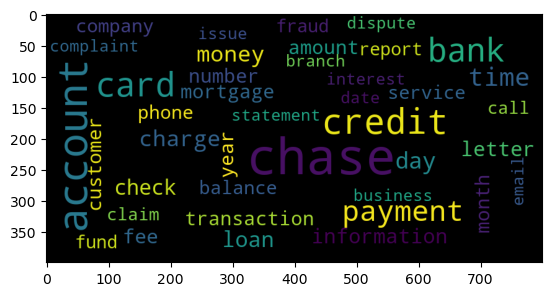

In [165]:
wordcloud.generate(text)
plt.imshow(wordcloud)

In [166]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [167]:
df_clean['preprocessed'][1]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.'

In [168]:
df_clean.head()

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq
1,good morning my name is xxxx xxxx and i apprec...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65
10,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32
11,"on xx/xx/2018, while trying to book a xxxx xx...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272
14,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96


### Unigrams

In [178]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigram = []

for token in df_clean['tokens']:
    uni = ngrams(token, 1)
    for word in uni:
        unigram.append(word)

In [179]:
len(unigram)

1138122

In [182]:
nltk.FreqDist(unigram).most_common(30)

[(('chase',), 74018),
 (('account',), 47660),
 (('credit',), 32809),
 (('card',), 30515),
 (('bank',), 28075),
 (('payment',), 21311),
 (('time',), 16281),
 (('day',), 13207),
 (('charge',), 12254),
 (('money',), 11980),
 (('loan',), 11003),
 (('check',), 10411),
 (('letter',), 9700),
 (('information',), 9670),
 (('fee',), 8997),
 (('transaction',), 8643),
 (('number',), 8617),
 (('month',), 8586),
 (('year',), 8420),
 (('amount',), 8317),
 (('mortgage',), 8197),
 (('customer',), 8189),
 (('balance',), 7794),
 (('service',), 7654),
 (('company',), 7643),
 (('phone',), 7594),
 (('fraud',), 7175),
 (('report',), 7066),
 (('fund',), 7049),
 (('call',), 6651)]

In [183]:
# top 10 unigram
word = []
count = []
for i in nltk.FreqDist(unigram).most_common(10):
    word.append(i[0][0])
    count.append(i[1])

In [184]:
top10_unigram = pd.DataFrame({'word':word,'frequency':count})

In [185]:
top10_unigram

,word,frequency
0,chase,74018
1,account,47660
2,credit,32809
3,card,30515
4,bank,28075
5,payment,21311
6,time,16281
7,day,13207
8,charge,12254
9,money,11980


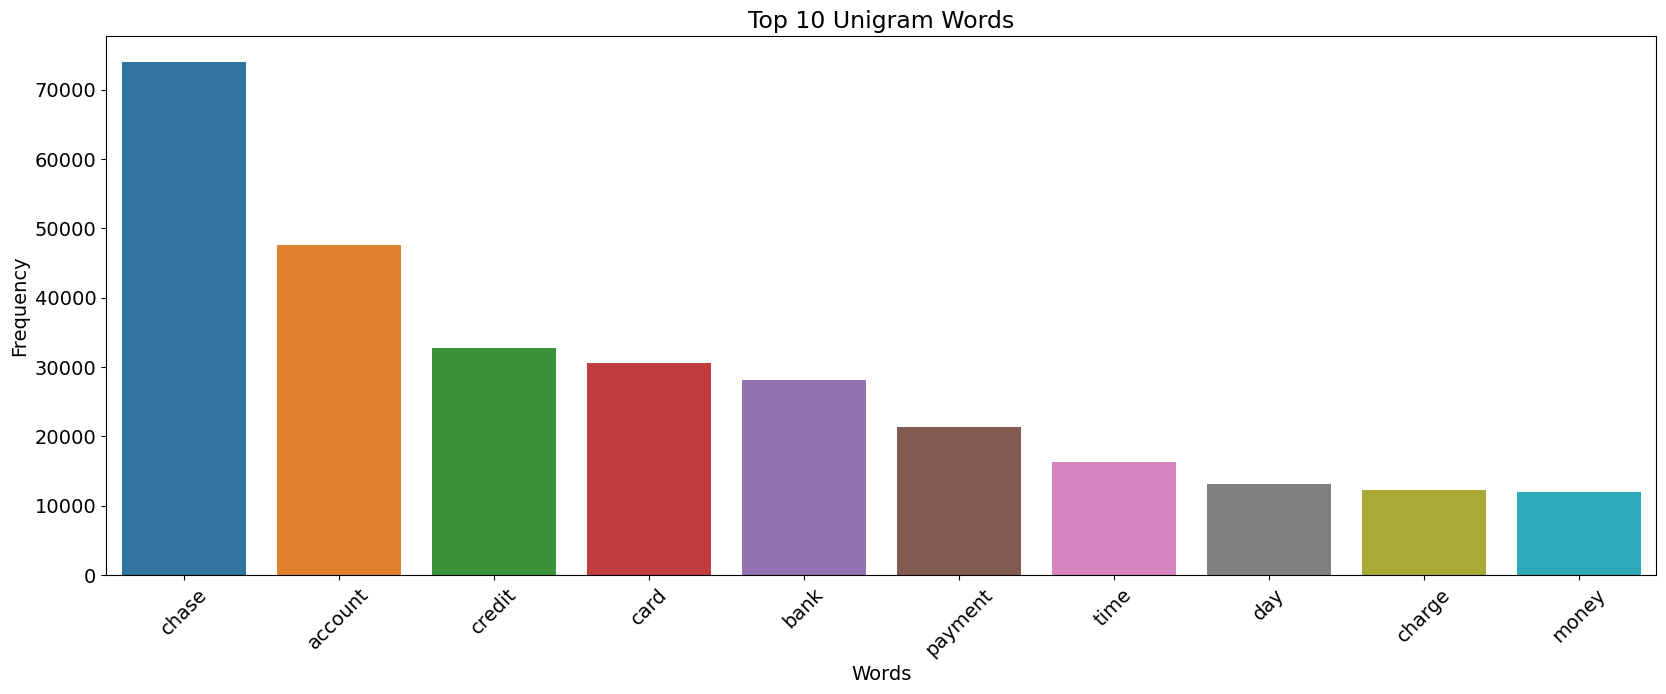

In [189]:
# top 10 unigram
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top10_unigram
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 10 Unigram Words', fontsize=17)

plt.show()

### Bigrams

In [192]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram = []
        
for token in df_clean['tokens']:
    bi = ngrams(token, 2)
    for word in bi:
        bigram.append(word)        
        
nltk.FreqDist(bigram).most_common(30)

[(('credit', 'card'), 12916),
 (('chase', 'bank'), 12202),
 (('account', 'chase'), 4476),
 (('credit', 'report'), 3871),
 (('chase', 'credit'), 3826),
 (('checking', 'account'), 3412),
 (('chase', 'account'), 3257),
 (('customer', 'service'), 3083),
 (('bank', 'account'), 2935),
 (('jp', 'morgan'), 2697),
 (('account', 'account'), 2565),
 (('morgan', 'chase'), 2521),
 (('card', 'chase'), 2406),
 (('debit', 'card'), 2048),
 (('chase', 'card'), 1973),
 (('credit', 'score'), 1716),
 (('card', 'account'), 1656),
 (('phone', 'call'), 1641),
 (('chase', 'chase'), 1583),
 (('payment', 'payment'), 1573),
 (('account', 'credit'), 1559),
 (('letter', 'chase'), 1473),
 (('money', 'account'), 1404),
 (('chase', 'customer'), 1378),
 (('payment', 'chase'), 1353),
 (('interest', 'rate'), 1308),
 (('bank', 'chase'), 1292),
 (('business', 'day'), 1267),
 (('phone', 'number'), 1250),
 (('account', 'number'), 1219)]

In [194]:
#Print the top 10 words in the bigram frequency
for i in nltk.FreqDist(bigram).most_common(10):
    print(i[0])

('credit', 'card')
('chase', 'bank')
('account', 'chase')
('credit', 'report')
('chase', 'credit')
('checking', 'account')
('chase', 'account')
('customer', 'service')
('bank', 'account')
('jp', 'morgan')


In [195]:
word = []
count = []
for i in nltk.FreqDist(bigram).most_common(10):
    word.append(i[0])
    count.append(i[1])

top10_bigram = pd.DataFrame({'word': word, 'frequency':count})
top10_bigram

,word,frequency
0,"(credit, card)",12916
1,"(chase, bank)",12202
2,"(account, chase)",4476
3,"(credit, report)",3871
4,"(chase, credit)",3826
5,"(checking, account)",3412
6,"(chase, account)",3257
7,"(customer, service)",3083
8,"(bank, account)",2935
9,"(jp, morgan)",2697


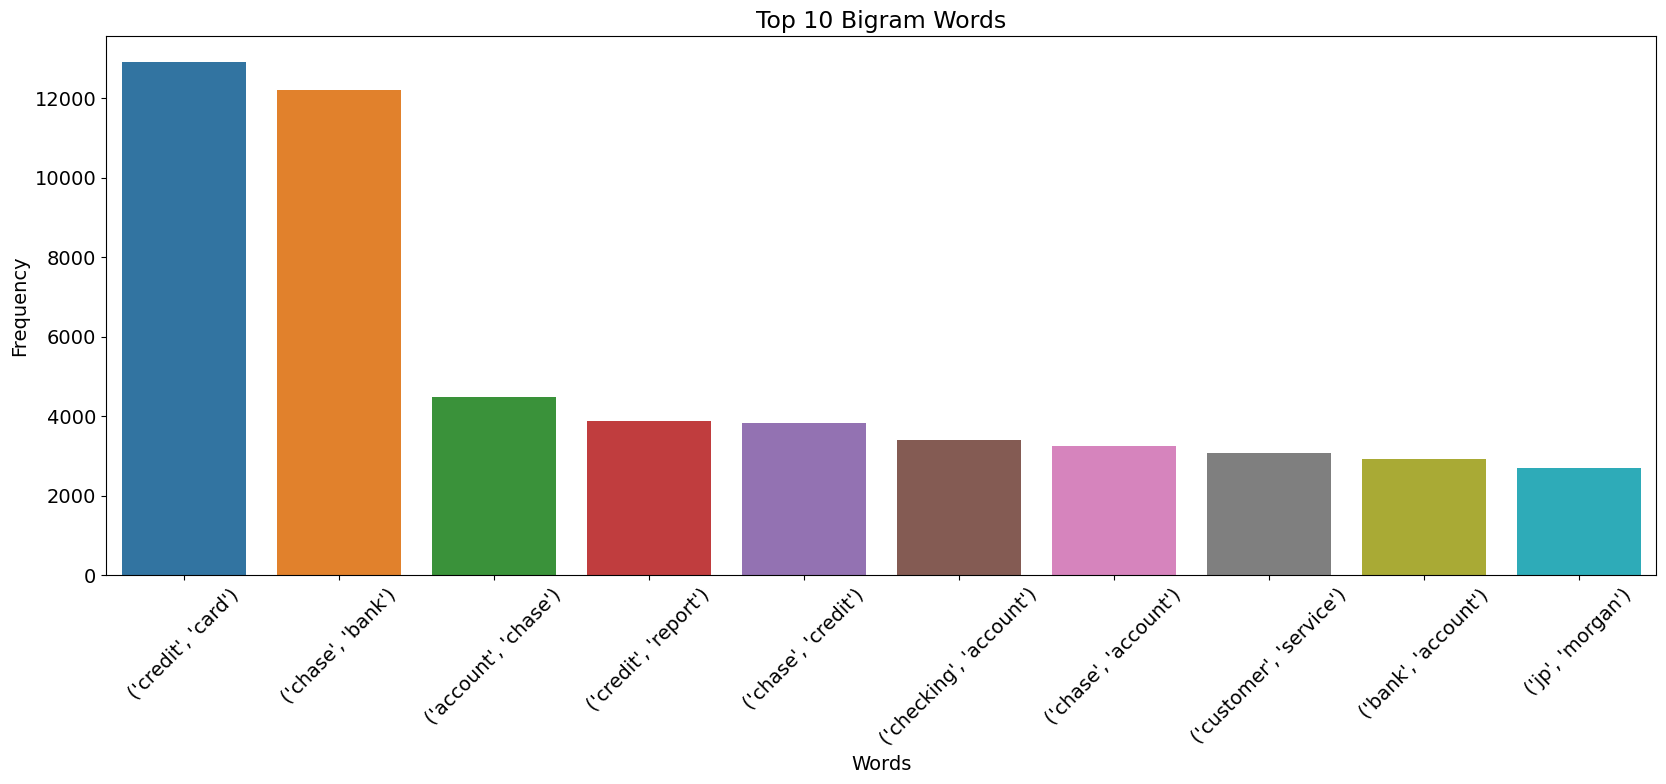

In [196]:
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top10_bigram
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 10 Bigram Words', fontsize=17)

'''
file_name = 'top_words'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)
'''

plt.show()

### Trigrams

In [197]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram = []

for i in df_clean['tokens']:
    tri = ngrams(i, 3)
    for word in tri:
        trigram.append(word)
        
nltk.FreqDist(trigram).most_common(30)

[(('chase', 'credit', 'card'), 2636),
 (('jp', 'morgan', 'chase'), 2194),
 (('credit', 'card', 'chase'), 1129),
 (('credit', 'card', 'account'), 1018),
 (('credit', 'card', 'company'), 1000),
 (('account', 'chase', 'bank'), 985),
 (('chase', 'bank', 'account'), 928),
 (('morgan', 'chase', 'bank'), 694),
 (('chase', 'customer', 'service'), 626),
 (('inquiry', 'credit', 'report'), 559),
 (('checking', 'account', 'chase'), 559),
 (('chase', 'checking', 'account'), 522),
 (('chase', 'bank', 'credit'), 518),
 (('credit', 'card', 'credit'), 514),
 (('chase', 'bank', 'chase'), 445),
 (('card', 'chase', 'bank'), 441),
 (('account', 'credit', 'card'), 439),
 (('card', 'credit', 'card'), 409),
 (('bank', 'credit', 'card'), 402),
 (('credit', 'reporting', 'agency'), 390),
 (('bank', 'chase', 'bank'), 377),
 (('credit', 'report', 'credit'), 364),
 (('charge', 'credit', 'card'), 356),
 (('account', 'chase', 'account'), 352),
 (('customer', 'service', 'representative'), 349),
 (('account', 'credit',

In [198]:
#Print the top 10 words in the trigram frequency
for i in nltk.FreqDist(trigram).most_common(10):
    print(i[0])

('chase', 'credit', 'card')
('jp', 'morgan', 'chase')
('credit', 'card', 'chase')
('credit', 'card', 'account')
('credit', 'card', 'company')
('account', 'chase', 'bank')
('chase', 'bank', 'account')
('morgan', 'chase', 'bank')
('chase', 'customer', 'service')
('inquiry', 'credit', 'report')


In [199]:

word = []
count = []
for i in nltk.FreqDist(trigram).most_common(10):
    word.append(i[0])
    count.append(i[1])

top10_trigram = pd.DataFrame({'word':word,'frequency':count})
top10_trigram

,word,frequency
0,"(chase, credit, card)",2636
1,"(jp, morgan, chase)",2194
2,"(credit, card, chase)",1129
3,"(credit, card, account)",1018
4,"(credit, card, company)",1000
5,"(account, chase, bank)",985
6,"(chase, bank, account)",928
7,"(morgan, chase, bank)",694
8,"(chase, customer, service)",626
9,"(inquiry, credit, report)",559


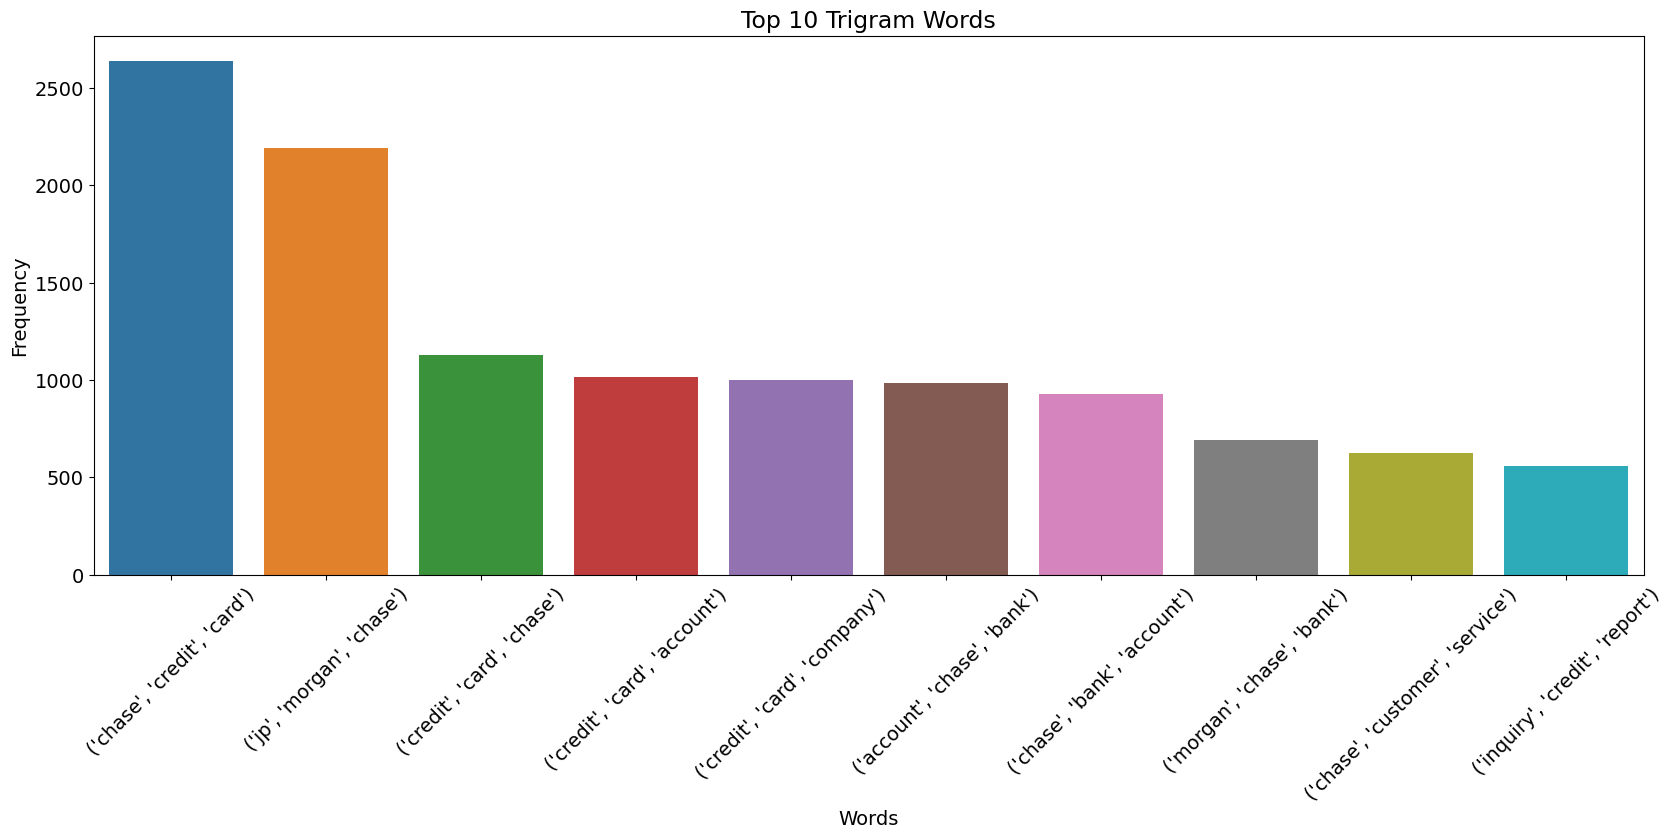

In [200]:
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top10_trigram
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 10 Trigram Words', fontsize=17)

'''
file_name = 'top_words'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)
'''

plt.show()

#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [201]:
df_clean['preprocessed'] = df_clean['preprocessed'].str.replace('xxxx','')

In [202]:
#All masked texts has been removed
df_clean

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq
1,good morning my name is and i appreciate it ...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92
2,i upgraded my card in xx/xx/2018 and was tol...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65
10,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32
11,"on xx/xx/2018, while trying to book a tick...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272
14,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,"[chase, card, customer, decade, solicitation, ...","[chase:NOUN, card:NOUN, customer:NOUN, decade:...",679,126
78309,"on wednesday, xx/xx/ i called chas, my visa ...","[wednesday, chas, visa, credit, card, provider...","[wednesday:NOUN, chas:NOUN, visa:NOUN, credit:...",2114,385
78310,i am not familiar with pay and did not unders...,"[pay, risk, consumer, chase, bank, app, chase,...","[pay:NOUN, risk:NOUN, consumer:NOUN, chase:NOU...",2319,412
78311,i have had flawless credit for 30 yrs. i've ha...,"[credit, yrs, chase, credit, card, chase, free...","[credit:NOUN, yrs:NOUN, chase:NOUN, credit:NOU...",2171,412


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [311]:
#Write your code here to initialise the TfidfVectorizer 
vect = TfidfVectorizer(stop_words='english', min_df=3, max_df=0.85)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [312]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean['preprocessed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [313]:
from sklearn.decomposition import NMF

## Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [314]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [315]:
W = nmf_model.fit_transform(X)
H = nmf_model.components_
len(vect.get_feature_names())

12663

In [316]:
W.shape

(21072, 5)

In [317]:
H.shape

(5, 12663)

In [318]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,funds,checking,closed,told,deposit,branch,accounts,00,said,deposited
Topic 2,xx,2020,2018,2019,00,received,letter,date,chase,payment,dated,called,dispute,sent,19
Topic 3,credit,card,report,inquiry,chase,cards,reporting,account,hard,inquiries,score,accounts,late,closed,debt
Topic 4,loan,mortgage,payment,chase,payments,home,modification,late,pay,paid,property,time,years,foreclosure,rate
Topic 5,card,00,chase,charge,charges,dispute,did,charged,called,fraud,fee,merchant,told,transaction,claim


In [319]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# Topic 1 is having words like account, bank, deposit so its related to bank accounts
# Topic 3 is having words like credit, card, cards, score so its related to credit cards
# Topic 4 is having words liek loan , mortgage , payment, years , month so its related to loans
# Topic 5 is having words like dispute, fraud, charged so its related to Disputes
# Topic 2 is having mixed random words so its others
topics = {
    '0': 'Bank Accounts',
    '1': 'Others',
    '2': 'Credit Card',
    '3': 'Loan',
    '4': 'Dispute'
}

In [322]:
W = pd.DataFrame(W, columns=[0,1,2,3,4], index=[f'Doc {i}' for i in range(X.shape[0])])
W

,0,1,2,3,4
Doc 0,0.022127,0.001515,0.013798,0.024055,0.007975
Doc 1,0.005334,0.071326,0.005019,0.000000,0.009644
Doc 2,0.000000,0.040481,0.042866,0.000000,0.010067
Doc 3,0.017195,0.042023,0.046748,0.008025,0.029700
Doc 4,0.061763,0.020910,0.000000,0.002757,0.001885
...,...,...,...,...,...
Doc 21067,0.000000,0.000000,0.056218,0.001665,0.045994
Doc 21068,0.006924,0.021244,0.003518,0.006028,0.054498
Doc 21069,0.016820,0.000000,0.008659,0.006528,0.028229
Doc 21070,0.000000,0.038065,0.025892,0.042295,0.048386


In [323]:
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W

,0,1,2,3,4,max_topic
Doc 0,0.022127,0.001515,0.013798,0.024055,0.007975,3
Doc 1,0.005334,0.071326,0.005019,0.000000,0.009644,1
Doc 2,0.000000,0.040481,0.042866,0.000000,0.010067,2
Doc 3,0.017195,0.042023,0.046748,0.008025,0.029700,2
Doc 4,0.061763,0.020910,0.000000,0.002757,0.001885,0
...,...,...,...,...,...,...
Doc 21067,0.000000,0.000000,0.056218,0.001665,0.045994,2
Doc 21068,0.006924,0.021244,0.003518,0.006028,0.054498,4
Doc 21069,0.016820,0.000000,0.008659,0.006528,0.028229,4
Doc 21070,0.000000,0.038065,0.025892,0.042295,0.048386,4


In [324]:
W.head(17)

,0,1,2,3,4,max_topic
Doc 0,0.022127,0.001515,0.013798,0.024055,0.007975,3
Doc 1,0.005334,0.071326,0.005019,0.000000,0.009644,1
Doc 2,0.000000,0.040481,0.042866,0.000000,0.010067,2
Doc 3,0.017195,0.042023,0.046748,0.008025,0.029700,2
Doc 4,0.061763,0.020910,0.000000,0.002757,0.001885,0
Doc 5,0.000000,0.001247,0.042551,0.000000,0.000000,2
Doc 6,0.056109,0.036880,0.002422,0.012529,0.000000,0
Doc 7,0.002867,0.014656,0.002485,0.055379,0.009594,3
Doc 8,0.021625,0.018173,0.000000,0.012605,0.064280,4
Doc 9,0.000000,0.000000,0.099257,0.000000,0.007267,2


In [325]:
df_clean['preprocessed'].head(20)

0     good morning my name is   and i appreciate it ...
1     i upgraded my   card in xx/xx/2018 and was tol...
2     chase card was reported on xx/xx/2019. however...
3     on xx/xx/2018, while trying to book a     tick...
4     my grand son give me check for {$1600.00} i de...
5                         can you please remove inquiry
6     with out notice j.p. morgan chase restricted m...
7     during the summer months, i experience a decli...
8     on  xx/xx/2019, i made a {$300.00} payment to ...
9     i have a chase credit card which is incorrectl...
10      mishandling of this account by chase auto and .
11    i have reached out to  several times in attemp...
12    i opened an account with chase bank on  and us...
13    to whom it may concern, chase bank charged wro...
14    my chase amazon card was declined for a cateri...
15    i opened the saving account for the {$25.00} b...
16      a sofa, love seat, table and chairs and was ...
17    my card went missing and i didnt realize i

In [326]:
W['max_topic']

Doc 0        3
Doc 1        1
Doc 2        2
Doc 3        2
Doc 4        0
            ..
Doc 21067    2
Doc 21068    4
Doc 21069    4
Doc 21070    4
Doc 21071    3
Name: max_topic, Length: 21072, dtype: int64

In [327]:
df_clean.shape[0]

21072

In [328]:
df_clean.head()

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq,Topic
0,good morning my name is and i appreciate it ...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92,0
1,i upgraded my card in xx/xx/2018 and was tol...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65,0
2,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32,0
3,"on xx/xx/2018, while trying to book a tick...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272,4
4,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96,0


In [329]:
df_clean = df_clean.reset_index(drop=True)

In [330]:
df_clean

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq,Topic
0,good morning my name is and i appreciate it ...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92,0
1,i upgraded my card in xx/xx/2018 and was tol...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65,0
2,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32,0
3,"on xx/xx/2018, while trying to book a tick...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272,4
4,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96,0
...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,"[chase, card, customer, decade, solicitation, ...","[chase:NOUN, card:NOUN, customer:NOUN, decade:...",679,126,1
21068,"on wednesday, xx/xx/ i called chas, my visa ...","[wednesday, chas, visa, credit, card, provider...","[wednesday:NOUN, chas:NOUN, visa:NOUN, credit:...",2114,385,0
21069,i am not familiar with pay and did not unders...,"[pay, risk, consumer, chase, bank, app, chase,...","[pay:NOUN, risk:NOUN, consumer:NOUN, chase:NOU...",2319,412,0
21070,i have had flawless credit for 30 yrs. i've ha...,"[credit, yrs, chase, credit, card, chase, free...","[credit:NOUN, yrs:NOUN, chase:NOUN, credit:NOU...",2171,412,0


In [331]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = "Not Assigned"
for i in range(df_clean.shape[0]):
    df_clean['Topic'][i] = W['max_topic'][i]  # write your code to assign topics to each rows.

In [362]:
df_clean.head(10)

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq,Topic
0,good morning my name is and i appreciate it ...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92,NaN
1,i upgraded my card in xx/xx/2018 and was tol...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65,NaN
2,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32,NaN
3,"on xx/xx/2018, while trying to book a tick...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272,NaN
4,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96,NaN
5,can you please remove inquiry,[inquiry],[inquiry:NOUN],29,5,NaN
6,with out notice j.p. morgan chase restricted m...,"[notice, morgan, chase, account, debit, card, ...","[notice:NOUN, morgan:NOUN, chase:NOUN, account...",2277,420,NaN
7,"during the summer months, i experience a decli...","[summer, month, decline, income, employment, m...","[summer:NOUN, month:NOUN, decline:NOUN, income...",1396,229,NaN
8,"on xx/xx/2019, i made a {$300.00} payment to ...","[payment, retailer, chase, pay, chase, website...","[payment:NOUN, retailer:NOUN, chase:NOUN, pay:...",3541,628,NaN
9,i have a chase credit card which is incorrectl...,"[chase, credit, card, datum, credit, report, c...","[chase:NOUN, credit:NOUN, card:NOUN, datum:NOU...",129,23,NaN


In [363]:
#Print the first 5 Complaint for each of the Topics
df_clean_temp=df_clean.groupby('Topic').head(5)
df_clean_temp.sort_values('Topic')

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq,Topic
0,good morning my name is and i appreciate it ...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92,NaN
1,i upgraded my card in xx/xx/2018 and was tol...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65,NaN
2,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32,NaN
3,"on xx/xx/2018, while trying to book a tick...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272,NaN
4,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96,NaN


### Map the clusters to topics/cluster names
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [335]:
#Create the dictionary of Topic names and Topics

Topic_names = {  
    0: 'Bank Account services',
    1: 'Others',
    2: 'Credit card or prepaid card',
    3: 'Mortgage/Loan',
    4: 'Theft/Dispute Reporting',
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [336]:
df_clean.shape

(21072, 6)

## Model Building and Inference

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

### Training data preparation

In [337]:
#Create the dictionary again of Topic names and Topics
Topic_names = {  
      'Bank Account services' : 0 ,
                     'Others' : 1 ,
'Credit card or prepaid card' : 2 ,
              'Mortgage/Loan' : 3 ,
    'Theft/Dispute Reporting' : 4 ,
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [338]:
df_clean.head(10)

,preprocessed,tokens,tokens_with_pos,complaint_length,word_freq,Topic
0,good morning my name is and i appreciate it ...,"[morning, name, stop, bank, cardmember, servic...","[morning:NOUN, name:NOUN, stop:NOUN, bank:NOUN...",486,92,3
1,i upgraded my card in xx/xx/2018 and was tol...,"[card, agent, upgrade, anniversary, date, agen...","[card:NOUN, agent:NOUN, upgrade:NOUN, annivers...",355,65,1
2,chase card was reported on xx/xx/2019. however...,"[chase, card, application, identity, consent, ...","[chase:NOUN, card:NOUN, application:NOUN, iden...",224,32,2
3,"on xx/xx/2018, while trying to book a tick...","[ticket, offer, ticket, reward, card, informat...","[ticket:NOUN, offer:NOUN, ticket:NOUN, reward:...",1502,272,2
4,my grand son give me check for {$1600.00} i de...,"[son, check, chase, account, fund, chase, bank...","[son:NOUN, check:NOUN, chase:NOUN, account:NOU...",477,96,0
5,can you please remove inquiry,[inquiry],[inquiry:NOUN],29,5,2
6,with out notice j.p. morgan chase restricted m...,"[notice, morgan, chase, account, debit, card, ...","[notice:NOUN, morgan:NOUN, chase:NOUN, account...",2277,420,0
7,"during the summer months, i experience a decli...","[summer, month, decline, income, employment, m...","[summer:NOUN, month:NOUN, decline:NOUN, income...",1396,229,3
8,"on xx/xx/2019, i made a {$300.00} payment to ...","[payment, retailer, chase, pay, chase, website...","[payment:NOUN, retailer:NOUN, chase:NOUN, pay:...",3541,628,4
9,i have a chase credit card which is incorrectl...,"[chase, credit, card, datum, credit, report, c...","[chase:NOUN, credit:NOUN, card:NOUN, datum:NOU...",129,23,2


In [339]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean.drop(columns=['tokens','tokens_with_pos','word_freq', 'complaint_length'])

In [340]:
training_data

,preprocessed,Topic
0,good morning my name is and i appreciate it ...,3
1,i upgraded my card in xx/xx/2018 and was tol...,1
2,chase card was reported on xx/xx/2019. however...,2
3,"on xx/xx/2018, while trying to book a tick...",2
4,my grand son give me check for {$1600.00} i de...,0
...,...,...
21067,after being a chase card customer for well ove...,2
21068,"on wednesday, xx/xx/ i called chas, my visa ...",4
21069,i am not familiar with pay and did not unders...,4
21070,i have had flawless credit for 30 yrs. i've ha...,4


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [341]:
y = training_data.pop('Topic')
X = training_data['preprocessed']

In [342]:
X.shape

(21072,)

In [343]:
y

0        3
1        1
2        2
3        2
4        0
        ..
21067    2
21068    4
21069    4
21070    4
21071    3
Name: Topic, Length: 21072, dtype: int64

In [344]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
#Write your code to get the Vector count
vector = cv.fit_transform(X)
#Write your code here to transform the word vector to tf-idf

In [345]:
print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


In [346]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [347]:
X_train.shape , X_test.shape

((16857,), (4215,))

In [348]:
td = TfidfVectorizer(max_features = 10000, ngram_range=(1,3))
X_train = td.fit_transform(X_train).toarray()
X_test = td.transform(X_test).toarray()

In [349]:
X_train.shape , X_test.shape

((16857, 10000), (4215, 10000))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [350]:
y_train.shape , y_test.shape

((16857,), (4215,))

### Logistic Regression

In [358]:
lr = LogisticRegression(solver='liblinear')
model = lr.fit(X_train,y_train)
#Making prediction on the test data
y_pred_lr = model.predict(X_test)

clf_report = classification_report(y_test,y_pred_lr)
print(F'ACC : {accuracy_score(y_test,y_pred_lr)}')
print(clf_report)

ACC : 0.9359430604982206
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       849
           1       0.96      0.89      0.92       677
           2       0.95      0.91      0.93       734
           3       0.94      0.96      0.95       857
           4       0.93      0.95      0.94      1098

    accuracy                           0.94      4215
   macro avg       0.94      0.93      0.93      4215
weighted avg       0.94      0.94      0.94      4215



### Random Forest

In [352]:
# Write your code here to build any 3 models and evaluate them using the required metrics
rf = RandomForestClassifier(n_estimators= 50)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.8474495848161329
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       849
           1       0.86      0.79      0.83       677
           2       0.87      0.85      0.86       734
           3       0.90      0.87      0.88       857
           4       0.82      0.83      0.82      1098

    accuracy                           0.85      4215
   macro avg       0.85      0.85      0.85      4215
weighted avg       0.85      0.85      0.85      4215



In [353]:
# Write your code here to build any 3 models and evaluate them using the required metrics
rf = RandomForestClassifier(n_estimators= 400)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.8702253855278766
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       849
           1       0.88      0.83      0.85       677
           2       0.87      0.88      0.87       734
           3       0.93      0.87      0.90       857
           4       0.85      0.86      0.85      1098

    accuracy                           0.87      4215
   macro avg       0.87      0.87      0.87      4215
weighted avg       0.87      0.87      0.87      4215



### Decision Tree

In [354]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
y_pred_dt = rf.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report

clf_report = classification_report(y_test,y_pred_dt)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.8702253855278766
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       849
           1       0.88      0.83      0.85       677
           2       0.87      0.88      0.87       734
           3       0.93      0.87      0.90       857
           4       0.85      0.86      0.85      1098

    accuracy                           0.87      4215
   macro avg       0.87      0.87      0.87      4215
weighted avg       0.87      0.87      0.87      4215



## Conclusion
- Logistic Regression is selected as the best model because
    - it has a good accuracy of 93.5%
    - it is fast and interpretable